# Timeseries Model on Sentinel-2 indices

In [1]:
import os 
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

os.chdir('/Users/kaushalk/Desktop/open_projects/Telengana_Crop_Health/')
# Add the 'src' directory to the Python path
from src.process_data import compute_indices_for_df, prepare_model_data, compute_monthly_indices_for_df

from src.visualize import plot_numerical_distributions, plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, f1_score

In [3]:
class CropTimeSeriesDataset(Dataset):
    def __init__(self, dataframe, time_series_columns, target_column, pad_value=-1):
        """
        Args:
            dataframe (pd.DataFrame): Input data.
            time_series_columns (list): List of time-series columns (M1_NDVI, M2_NDVI, etc.).
            target_column (str): Target column name (classification label).
            pad_value (float): Value to use for padding shorter sequences.
        """
        self.data = dataframe
        self.time_series_columns = time_series_columns
        self.target_column = target_column
        self.pad_value = pad_value

        self.sequences, self.lengths, self.targets = self._prepare_data()

    def _prepare_data(self):
        sequences = []
        lengths = []
        targets = []

        for _, row in self.data.iterrows():
            harvest_month = row["HDate"]
            if pd.isna(harvest_month):
                continue  # Skip if harvest month is missing

            # Get valid columns up to `HDate`
            valid_columns = [col for col in self.time_series_columns if int(col.split("_")[0][1:]) <= harvest_month]

            # Extract time-series features for months up to `HDate`
            ts_features = row[valid_columns].astype(float).values
            ts_features = ts_features.reshape(len(valid_columns) // len(set(col.split("_")[1] for col in valid_columns)), -1)

            # Ensure all sequences have the same number of features per time step
            num_features = ts_features.shape[1]

            # Store sequence, its valid length, and the target category
            sequences.append(torch.tensor(ts_features, dtype=torch.float32))  
            lengths.append(len(ts_features))  # Store original sequence length
            targets.append(row[self.target_column])  

        return sequences, lengths, torch.tensor(targets, dtype=torch.int64)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.lengths[idx], self.targets[idx]

def collate_fn(batch):
    """
    Custom collate function to handle variable-length sequences for LSTMs.
    Works for both training (with targets) and testing (without targets).
    """
    if len(batch[0]) == 3:  # Training mode
        sequences, lengths, targets = zip(*batch)
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=-1)
        lengths = torch.tensor(lengths, dtype=torch.int64)
        targets = torch.tensor(targets, dtype=torch.int64)
        return sequences_padded, lengths, targets

    elif len(batch[0]) == 2:  # Test mode (No labels)
        sequences, lengths = zip(*batch)
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=-1)
        lengths = torch.tensor(lengths, dtype=torch.int64)
        return sequences_padded, lengths

In [5]:
df = pd.read_csv('data/Model/Input/train_monthly_indeces.csv', index_col=0)
# Identify time-series columns (all M1-M23 features)
columns_to_drop = [col for col in df.columns if 'LCI' in col or 'MoistureIndex' in col] #'LSWI' in col or
df = df.drop(columns=columns_to_drop)

time_series_columns = [col for col in df.columns if col.startswith("M")]

# Ensure `HDate` is numeric
df["HDate"] = pd.to_datetime(df["HDate"], errors='coerce').dt.month

# Category Mapping
category_mapper = {'Healthy': 0, 'Diseased': 1, 'Pests': 2, 'Stressed': 3}
df["category"] = df["category"].map(category_mapper)
# Fill TS na value
df[time_series_columns] = df[time_series_columns].fillna(0.0)  # Use 0 or any neutral value

### Pytorch Lightning

In [ ]:
import torch.nn as nn
import pytorch_lightning as pl
import torch.optim as optim
from torchmetrics import Accuracy

class LSTMModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_layers=2, num_classes=4):
        """
        LSTM Model for time-series classification.
        """
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Ensure LSTM `input_size=3` to match `num_features=3`
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        # Debugging shape before passing to LSTM

        lengths = lengths.cpu()  # Move to CPU for packing
        packed_seq = torch.nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)

        out, _ = self.lstm(packed_seq)  # LSTM forward pass
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)

        # Extract last valid timestep based on sequence length
        out = out[torch.arange(out.size(0)), lengths - 1]

        return self.fc(out)

In [28]:
import pytorch_lightning as pl
import torch.optim as optim
from torchmetrics.classification import Accuracy

class LSTMLitModel(pl.LightningModule):
    def __init__(self, input_size=3, hidden_size=128, num_layers=2, num_classes=4, learning_rate=1e-3, class_weights=None):
        super(LSTMLitModel, self).__init__()

        self.save_hyperparameters()
        self.model = LSTMModel(input_size, hidden_size, num_layers, num_classes)

        # Use CrossEntropyLoss with Label Smoothing
        self.criterion = nn.CrossEntropyLoss(weight=class_weights.to(self.device) if class_weights is not None else None, label_smoothing=0.1)
        
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.learning_rate = learning_rate

    def forward(self, x, lengths):
        return self.model(x, lengths)

    def training_step(self, batch, batch_idx):
        sequences, lengths, targets = batch
        outputs = self(sequences, lengths)
        loss = self.criterion(outputs, targets)
        acc = self.accuracy(outputs, targets)

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        sequences, lengths, targets = batch
        outputs = self(sequences, lengths)
        loss = self.criterion(outputs, targets)
        acc = self.accuracy(outputs, targets)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

In [30]:
from torch.utils.data import DataLoader, random_split

# Load dataset
dataset = CropTimeSeriesDataset(df, time_series_columns, target_column="category")

# Split dataset (80% train, 20% val)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [32]:
from sklearn.utils.class_weight import compute_class_weight

class_labels = df["category"].astype("category").cat.codes.values
num_classes = len(np.unique(class_labels))

# Compute class weights (log transformation)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(class_labels), y=class_labels)
class_weights = torch.tensor(np.log1p(class_weights), dtype=torch.float32)  # Use log-smoothing

print("Class Weights (Log Transformed):", class_weights)

Class Weights (Log Transformed): tensor([0.2647, 1.6410, 1.6225, 1.7338])


In [34]:
# Initialize Model with Correct Input Size
from pytorch_lightning.callbacks import RichProgressBar

model = LSTMLitModel(
    input_size=3,
    hidden_size=128,
    num_layers=2,
    num_classes=4,
    learning_rate=1e-3,
    class_weights=class_weights  # Pass class weights here!
)

# PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=20, 
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[RichProgressBar()]  # Fix widget issue
)

# Train the model
trainer.fit(model, train_loader, val_loader)

Epoch 29/29 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198/198 0:00:02 • 0:00:00 92.09it/s v_num: 15.000 train_loss: 1.518   
                                                                                 train_acc: 0.667 val_loss: 1.582  
                                                                                 val_acc: 0.813                    

`Trainer.fit` stopped: `max_epochs=30` reached.


In [36]:
# Ensure the model is in evaluation mode
model.eval()

# Lists to store predictions and ground truth labels
all_preds = []
all_labels = []

# Disable gradient computation for inference
with torch.no_grad():
    for batch in val_loader:
        x, lengths, y = batch
        # Move data to the correct device (MPS or CPU)
        x = x.to(model.device)
        lengths = lengths.to(model.device)
        y = y.to(model.device)

        # Get model predictions
        y_hat = model(x, lengths)
        preds = torch.argmax(y_hat, dim=1)  # Get the predicted class

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Generate classification report
classification_rep = classification_report(
    all_labels, all_preds, target_names=list(category_mapper.keys())
)

# Compute weighted F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.82      1.00      0.90      1293
    Diseased       0.00      0.00      0.00       102
       Pests       0.00      0.00      0.00        97
    Stressed       0.00      0.00      0.00        86

    accuracy                           0.82      1578
   macro avg       0.20      0.25      0.23      1578
weighted avg       0.67      0.82      0.74      1578


Weighted F1 Score: 0.7377379737947297


/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### TCCN Model

In [39]:
class TCNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=3, kernel_size=3, dropout=0.2):
        super(TCNModel, self).__init__()

        # Temporal Convolutional Layers
        self.conv_layers = nn.ModuleList()
        for i in range(num_layers):
            dilation = 2 ** i  # Increasing dilation for long-term dependencies
            in_channels = input_size if i == 0 else hidden_size
            self.conv_layers.append(nn.Conv1d(in_channels, hidden_size, kernel_size, padding=dilation, dilation=dilation))

        self.dropout = nn.Dropout(dropout)

        # Fully Connected Output Layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        """
        x: (batch_size, seq_length, num_features)
        Convert to (batch_size, num_features, seq_length) for Conv1D
        """
        x = x.permute(0, 2, 1)  # (batch_size, num_features, seq_length)

        for conv in self.conv_layers:
            x = torch.relu(conv(x))  # Apply each Conv1D layer
            x = self.dropout(x)

        x = x.mean(dim=2)  # Global Average Pooling over time dimension

        return self.fc(x)  # Final classification output

In [41]:
class TCNLitModel(pl.LightningModule):
    def __init__(self, input_size=3, hidden_size=128, num_classes=4, learning_rate=1e-3):
        super(TCNLitModel, self).__init__()

        self.model = TCNModel(input_size, hidden_size, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.learning_rate = learning_rate

    def forward(self, x, lengths):
        return self.model(x, lengths)

    def training_step(self, batch, batch_idx):
        sequences, lengths, targets = batch
        outputs = self(sequences, lengths)
        loss = self.criterion(outputs, targets)
        acc = self.accuracy(outputs, targets)

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        sequences, lengths, targets = batch
        outputs = self(sequences, lengths)
        loss = self.criterion(outputs, targets)
        acc = self.accuracy(outputs, targets)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

In [43]:
from torch.utils.data import DataLoader, random_split

# Load dataset
dataset = CropTimeSeriesDataset(df, time_series_columns, target_column="category")

# Split dataset (80% train, 20% val)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [45]:
# Initialize Model
model = TCNLitModel(
    input_size=3,
    hidden_size=128,
    num_classes=len(df["category"].unique()),
    learning_rate=1e-3
)

# Train Model
trainer = pl.Trainer(
    max_epochs=50,  # Train for more epochs
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
     callbacks=[RichProgressBar()]  # Fix widget issue
)

trainer.fit(model, train_loader, val_loader)

Epoch 49/49 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198/198 0:00:03 • 0:00:00 64.99it/s v_num: 16.000 train_loss: 0.212   
                                                                                 train_acc: 1.000 val_loss: 0.657  
                                                                                 val_acc: 0.826                    

`Trainer.fit` stopped: `max_epochs=50` reached.


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.83      1.00      0.90      1304
    Diseased       0.00      0.00      0.00        85
       Pests       0.00      0.00      0.00        96
    Stressed       0.00      0.00      0.00        93

    accuracy                           0.83      1578
   macro avg       0.21      0.25      0.23      1578
weighted avg       0.68      0.83      0.75      1578

Confusion Matrix:
[[1304    0    0    0]
 [  85    0    0    0]
 [  96    0    0    0]
 [  93    0    0    0]]


/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


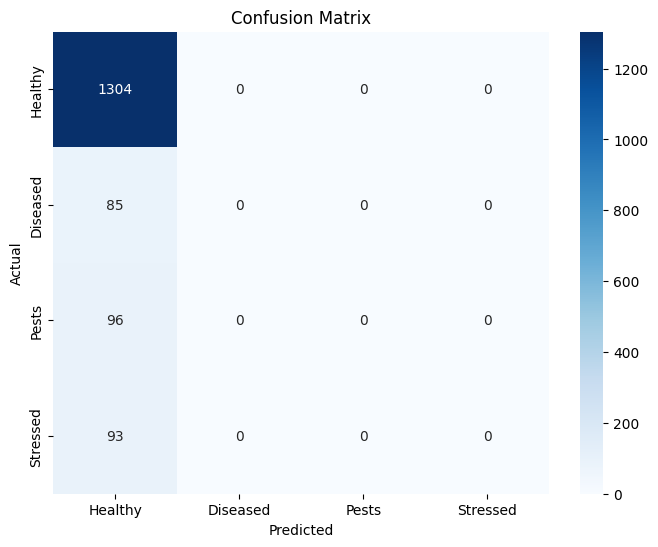

In [47]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on validation set
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_targets = []

    # Disable gradient calculation during evaluation
    with torch.no_grad():
        for batch in dataloader:
            sequences, lengths, targets = batch
            outputs = model(sequences, lengths)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Convert lists to numpy arrays for ease of use
    all_preds = torch.tensor(all_preds)
    all_targets = torch.tensor(all_targets)

    return all_preds, all_targets

# Get predictions and targets
predictions, targets = evaluate_model(model, val_loader)

# Classification Report
print("Classification Report:")
print(classification_report(targets, predictions, target_names=["Healthy", "Diseased", "Pests", "Stressed"]))

# Confusion Matrix
conf_matrix = confusion_matrix(targets, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
def plot_confusion_matrix(conf_matrix, labels):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Call to plot confusion matrix
plot_confusion_matrix(conf_matrix, labels=["Healthy", "Diseased", "Pests", "Stressed"])

In [ ]:
df[time_series_columns].columns

In [ ]:
# Create dataset
dataset = CropTimeSeriesDataset(df, time_series_columns, "category")

# Create DataLoader with collate function
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [ ]:
# Fetch a batch from dataloader
for batch in dataloader:
    sequences, lengths, targets = batch
    break  # Only take the first batch for inspection

# Print batch structure
print(f"Batch Sequence Shape: {sequences.shape}")  # (batch_size, max_seq_length, num_features)
print(f"Batch Lengths Shape: {lengths.shape}")  # (batch_size,)
print(f"Batch Targets Shape: {targets.shape}")  # (batch_size,)

# Number of features per time step
num_features = sequences.shape[2]
print(f"Number of Features per Month: {num_features}")

# Print first sample
print("\nFirst Sample - Time-Series Data (First 5 months):")
print(sequences[0, :5])  # Print first 5 months for the first sample

# Print first sample's valid sequence length
print("\nValid Months for First Sample:", lengths[0].item())

# Print first sample's target class
print("\nTarget Category for First Sample:", targets[0].item())

## LSTM Model

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [9]:
class CropHealthLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        """
        Args:
            input_size (int): Number of time-series features (NDVI, EVI, etc.).
            hidden_size (int): Number of hidden units in the LSTM.
            num_layers (int): Number of stacked LSTM layers.
            output_size (int): Number of classification categories.
            dropout (float): Dropout rate for regularization.
        """
        super(CropHealthLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        # Pack padded sequence (ignores padding in LSTM computations)
        packed_input = torch.nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.lstm(packed_input)
        hidden = hidden[-1]  # Take the last hidden state
        hidden = self.dropout(hidden)
        out = self.fc(hidden)  # Linear layer (logits)
        return out

In [11]:
from torch.utils.data import random_split
# Load dataset
dataset = CropTimeSeriesDataset(df, time_series_columns, target_column="category")

# Define train-validation split ratio
train_size = int(0.8 * len(dataset))  # 80% training, 20% validation
val_size = len(dataset) - train_size

# Split dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

### Data Balanacing 

In [81]:
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Hyperparameters
input_size =  len(time_series_columns) // 23  # Number of index features per month
hidden_size = 128  # Number of LSTM hidden units
num_layers = 2  # Number of stacked LSTM layers
output_size = len(category_mapper)  # Number of classes (4 categories)

# Initialize Model
model = CropHealthLSTM(input_size, hidden_size, num_layers, output_size, dropout=0.0).to(device)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(df["category"]), y=df["category"])
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Use weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.0009, )  # L2 regularization, weight_decay=1e-3

In [116]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha  # Class weights tensor
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction="none", weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt)**self.gamma * ce_loss
        return focal_loss.mean()

In [118]:
class BiLSTM_Attention(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size, hidden_size, 
            num_layers=2, bidirectional=True, batch_first=True
        )
        self.attention = nn.Sequential(
            nn.Linear(2*hidden_size, 128),
            nn.Tanh(),
            nn.Linear(128, 1, bias=False)
        )
        self.fc = nn.Linear(2*hidden_size, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_len=23, features=3)
        out, _ = self.bilstm(x)  # (batch_size, 23, 2*hidden_size)
        
        # Temporal Attention
        attn_weights = torch.softmax(self.attention(out).squeeze(-1), dim=1)
        context = torch.sum(out * attn_weights.unsqueeze(-1), dim=1)
        
        return self.fc(context)

In [122]:
import pytorch_lightning as plclass CropHealthModel(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_classes, class_weights):
        super().__init__()
        self.model = BiLSTM_Attention(input_size=3, hidden_size=128, num_classes=4)
        self.criterion = FocalLoss(alpha=class_weights, gamma=2.0)
        self.accuracy = Accuracy(task="multiclass", num_classes=4)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=1e-3, weight_decay=1e-4)  # L2 regularization

In [83]:
num_epochs = 20  # Number of training epochs

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for sequences, lengths, targets in train_loader:
        sequences, lengths, targets = sequences.to(device), lengths.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(sequences, lengths)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    train_acc = 100 * correct / total
    avg_loss = total_loss / len(train_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

Epoch [1/20], Loss: 1.3857, Train Accuracy: 73.28%
Epoch [2/20], Loss: 1.3835, Train Accuracy: 77.77%
Epoch [3/20], Loss: 1.3827, Train Accuracy: 74.68%
Epoch [4/20], Loss: 1.3803, Train Accuracy: 77.67%
Epoch [5/20], Loss: 1.3789, Train Accuracy: 78.34%
Epoch [6/20], Loss: 1.3792, Train Accuracy: 75.34%
Epoch [7/20], Loss: 1.3780, Train Accuracy: 67.43%
Epoch [8/20], Loss: 1.3773, Train Accuracy: 67.32%
Epoch [9/20], Loss: 1.3759, Train Accuracy: 72.98%
Epoch [10/20], Loss: 1.3753, Train Accuracy: 66.29%
Epoch [11/20], Loss: 1.3770, Train Accuracy: 64.72%
Epoch [12/20], Loss: 1.3749, Train Accuracy: 56.23%
Epoch [13/20], Loss: 1.3722, Train Accuracy: 65.36%
Epoch [14/20], Loss: 1.3726, Train Accuracy: 60.16%
Epoch [15/20], Loss: 1.3706, Train Accuracy: 56.64%
Epoch [16/20], Loss: 1.3690, Train Accuracy: 49.22%
Epoch [17/20], Loss: 1.3679, Train Accuracy: 53.19%
Epoch [18/20], Loss: 1.3662, Train Accuracy: 53.90%
Epoch [19/20], Loss: 1.3674, Train Accuracy: 39.10%
Epoch [20/20], Loss: 

In [85]:
def evaluate_model(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for sequences, lengths, targets in val_loader:
            sequences, lengths, targets = sequences.to(device), lengths.to(device), targets.to(device)
            outputs = model(sequences, lengths)

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    # Compute Accuracy and F1 Score
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_f1_score = f1_score(all_labels, all_preds, average="weighted")

    print(f"Validation Accuracy: {val_accuracy:.2f}")
    print(f"Validation F1 Score: {val_f1_score:.2f}")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds))

    return all_labels, all_preds

# Get validation results
y_true, y_pred = evaluate_model(model, val_loader)

Validation Accuracy: 0.49
Validation F1 Score: 0.55

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.57      0.67      1276
           1       0.06      0.25      0.10        95
           2       0.06      0.15      0.09       101
           3       0.00      0.00      0.00       106

    accuracy                           0.49      1578
   macro avg       0.23      0.24      0.21      1578
weighted avg       0.65      0.49      0.55      1578



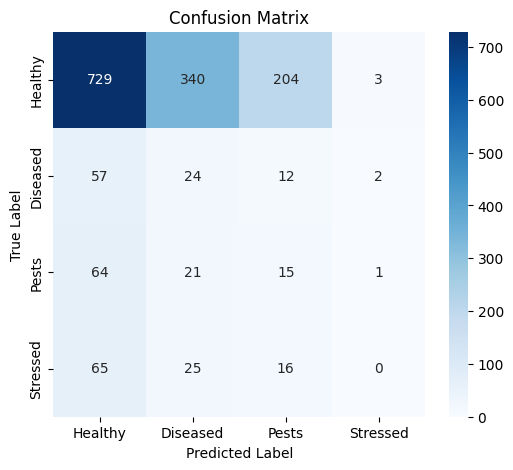

In [87]:
def plot_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Define class labels for confusion matrix
class_labels = list(category_mapper.keys())

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, class_labels)

## Test & Submission File 

In [90]:
test_df = pd.read_csv('data/Model/Input/test_monthly_indeces.csv', index_col=0)
# Identify time-series columns (all M1-M23 features)
#columns_to_drop = [col for col in df.columns if 'LCI' in col or 'MoistureIndex' in col] #'LSWI' in col or
test_df = test_df.drop(columns=columns_to_drop)

In [92]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2718 entries, 0 to 2717
Columns: 111 entries, FarmID to M23_GNDVI
dtypes: float64(92), int64(6), object(13)
memory usage: 2.3+ MB


In [94]:
# Load test dataset
test_df = pd.read_csv("data/processed/input_data/test_monthly_index.csv", index_col=0)

# Identify time-series columns (M1_NDVI, M2_EVI, etc.)
test_time_series_columns = [col for col in test_df.columns if col.startswith("M")]

# Ensure there are no NaNs (replace missing values)
test_df[test_time_series_columns] = test_df[test_time_series_columns].fillna(0.0)
test_df.head()

,FarmID,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,CNext,...,M21_NDRE,M21_GNDVI,M22_EVI,M22_MoistureIndex,M22_NDRE,M22_GNDVI,M23_EVI,M23_MoistureIndex,M23_NDRE,M23_GNDVI
0,483053,Paddy,Telangana,Medak,Nizampet,2023-01-11 0:00:00,2024-04-27 0:00:00,83,78,Pea,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,779677,Paddy,Telangana,Medak,Nizampet,2023-12-20 0:00:00,2024-05-28 0:00:00,91,63,Lentil,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,85197,Paddy,Telangana,Medak,Nizampet,2023-11-12 0:00:00,2024-05-14 0:00:00,81,99,Lentil,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1331840,Paddy,Telangana,Medak,Nizampet,2023-11-29 0:00:00,2024-05-18 0:00:00,94,89,Pea,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,544841,Paddy,Telangana,Medak,Nizampet,2023-12-30 0:00:00,2024-05-22 0:00:00,87,98,Pea,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
def collate_fn_test(batch):
    """
    Custom collate function to handle variable-length sequences for LSTMs.
    Works for both training (with targets) and testing (without targets).
    """
    if len(batch[0]) == 3:  # Training mode
        sequences, lengths, targets = zip(*batch)
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=-1)
        lengths = torch.tensor(lengths, dtype=torch.int64)
        targets = torch.tensor(targets, dtype=torch.int64)
        return sequences_padded, lengths, targets

    elif len(batch[0]) == 2:  # Test mode (No labels)
        sequences, lengths = zip(*batch)
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=-1)
        lengths = torch.tensor(lengths, dtype=torch.int64)
        return sequences_padded, lengths

In [98]:
class TestCropTimeSeriesDataset(Dataset):
    def __init__(self, dataframe, time_series_columns, pad_value=-1):
        """
        Args:
            dataframe (pd.DataFrame): Test dataset.
            time_series_columns (list): List of time-series index columns.
            pad_value (float): Padding value for missing months.
        """
        self.data = dataframe
        self.time_series_columns = time_series_columns
        self.pad_value = pad_value
        self.sequences, self.lengths = self._prepare_data()

    def _prepare_data(self):
        sequences = []
        lengths = []

        for _, row in self.data.iterrows():
            valid_columns = [col for col in self.time_series_columns if row[col] is not None]

            # Extract time-series features
            ts_features = row[valid_columns].astype(float).values.reshape(len(valid_columns) // len(set(col.split("_")[1] for col in valid_columns)), -1)

            valid_length = ts_features.shape[0]  # Store valid months

            sequences.append(torch.tensor(ts_features, dtype=torch.float32))
            lengths.append(valid_length)

        return sequences, lengths

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.lengths[idx]  # Only 2 values (no target)

In [100]:
# Create test dataset
test_dataset = TestCropTimeSeriesDataset(test_df, test_time_series_columns)

# Create DataLoader for inference (Use modified collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [104]:
next(iter(train_loader))[0].shape

torch.Size([32, 10, 4])

In [106]:
# Ensure model is in evaluation mode
model.eval()
predictions = []

with torch.no_grad():
    for sequences, lengths in test_loader:
        sequences, lengths = sequences.to(device), lengths.to(device)
        outputs = model(sequences, lengths)

        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())  # Convert to list

In [108]:
#category_mapper = {label: idx for idx, label in enumerate(data['category'].unique()) if pd.notna(label)}
idx_to_category_mapper = {idx: label for idx, label in enumerate(df['category'].unique()) if pd.notna(label)}

In [110]:
test_df['Target'] = predictions
test_df['Target'] = test_df['Target'].astype(int).map(idx_to_category_mapper)

In [112]:
test_df[["FarmID", "Target"]].groupby('Target').count()

,FarmID
Target,
0,2715
1,3
